# Compare models

1. Load available configurations
2. Load validation predictions
    - calculate absolute error
    - select top N for plotting by MAE from smallest (best) to largest (worst) (top N as specified, default 5)
    - correlation per sample, correlation per feat, correlation overall
    - MAE plots
3. Load test data predictions
    - as for validation data
    - top N based on validation data

In [1]:
import logging
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from IPython.display import display

import vaep
import vaep.imputation
import vaep.models
import vaep.nb
from vaep.analyzers import compare_predictions
from vaep.io import datasplits
from vaep.models.collect_dumps import collect, select_content

pd.options.display.max_rows = 30
pd.options.display.min_rows = 10
pd.options.display.max_colwidth = 100

plt.rcParams.update({'figure.figsize': (4, 2)})
vaep.plotting.make_large_descriptors(7)

logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.WARNING)


def load_config_file(fname: Path, first_split='config_') -> dict:
    with open(fname) as f:
        loaded = yaml.safe_load(f)
    key = f"{select_content(fname.stem, first_split=first_split)}"
    return key, loaded


def build_text(s):
    ret = ''
    if not np.isnan(s["latent_dim"]):
        ret += f'LD: {int(s["latent_dim"])} '
    try:
        if len(s["hidden_layers"]):
            t = ",".join(str(x) for x in s["hidden_layers"])
            ret += f"HL: {t}"
    except TypeError:
        # nan
        pass
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # change default to pickled files
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
models: str = 'Median,CF,DAE,VAE'  # picked models to compare (comma separated)
sel_models: str = ''  # user defined comparison (comma separated)
# Restrict plotting to top N methods for imputation based on error of validation data, maximum 10
plot_to_n: int = 5
feat_name_display: str = None  # display name for feature name in plural (e.g. 'protein groups')
save_agg_pred: bool = False  # save aggregated predictions of validation and test data

In [4]:
# Parameters
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
folder_experiment = "runs/dev_dataset_small/proteinGroups_N50"
models = "Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MICE-CART,MICE-NORM,MINDET,MINIMUM,MINPROB,MLE,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: fn_rawfile_metadata


root - INFO     Removed from global namespace: models


root - INFO     Removed from global namespace: sel_models


root - INFO     Removed from global namespace: plot_to_n


root - INFO     Removed from global namespace: feat_name_display


root - INFO     Removed from global namespace: save_agg_pred


{'folder_experiment': 'runs/dev_dataset_small/proteinGroups_N50',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'models': 'Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MICE-CART,MICE-NORM,MINDET,MINIMUM,MINPROB,MLE,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO',
 'sel_models': '',
 'plot_to_n': 5,
 'feat_name_display': None,
 'save_agg_pred': False}

In [6]:
args = vaep.nb.args_from_dict(args)
args

{'data': Path('runs/dev_dataset_small/proteinGroups_N50/data'),
 'feat_name_display': None,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'models': 'Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MICE-CART,MICE-NORM,MINDET,MINIMUM,MINPROB,MLE,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO',
 'out_figures': Path('runs/dev_dataset_small/proteinGroups_N50/figures'),
 'out_folder': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_metrics': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_models': Path('runs/dev_dataset_small/proteinGroups_N50'),
 'out_preds': Path('runs/dev_dataset_small/proteinGroups_N50/preds'),
 'plot_to_n': 5,
 'save_agg_pred': False,
 'sel_models': ''}

In [7]:
figures = {}
dumps = {}

In [8]:
TARGET_COL = 'observed'
METRIC = 'MAE'
MIN_FREQ = None
MODELS_PASSED = args.models.split(',')
MODELS = MODELS_PASSED.copy()
FEAT_NAME_DISPLAY = args.feat_name_display
SEL_MODELS = None
if args.sel_models:
    SEL_MODELS = args.sel_models.split(',')

In [9]:
# list(sns.color_palette().as_hex()) # string representation of colors
if args.plot_to_n > 10:
    logger.warning("Set maximum of models to 10 (maximum)")
    args.overwrite_entry('plot_to_n', 10)

In [10]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/dev_dataset_small/proteinGroups_N50/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/dev_dataset_small/proteinGroups_N50/data/test_y.csv


vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/2_1_fake_na_val_test_splits.png


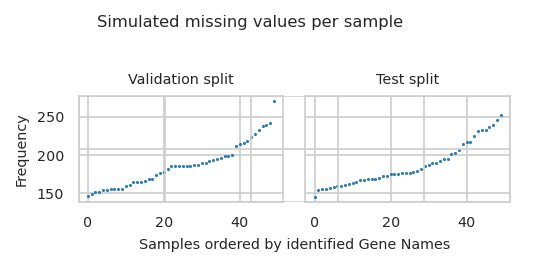

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)

vaep.plotting.data.plot_observations(data.val_y.unstack(), ax=axes[0],
                                     title='Validation split', size=1, xlabel='')
vaep.plotting.data.plot_observations(data.test_y.unstack(), ax=axes[1],
                                     title='Test split', size=1, xlabel='')
fig.suptitle("Simulated missing values per sample", size=8)
# hide axis and use only for common x label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(f'Samples ordered by identified {data.val_y.index.names[-1]}')
group = 1
fname = args.out_figures / f'2_{group}_fake_na_val_test_splits.png'
figures[fname.stem] = fname
vaep.savefig(fig, name=fname)

## data completeness across entire data

In [12]:
# load frequency of training features...
# needs to be pickle -> index.name needed
freq_feat = vaep.io.datasplits.load_freq(args.data, file='freq_features.json')
freq_feat.head()  # training data

AAAS    50
AACS    41
AAMDC   34
AAMP    49
AAR2    45
Name: freq, dtype: int64

<Axes: xlabel='Gene Names', ylabel='Proportion of identification in samples'>

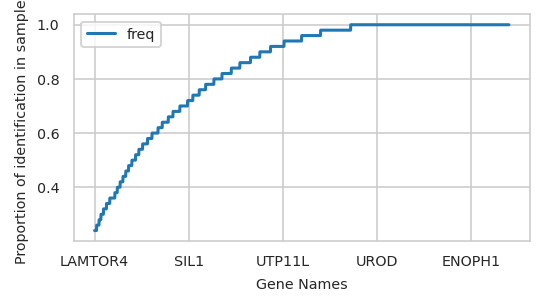

In [13]:
prop = freq_feat / len(data.train_X.index.levels[0])
prop.sort_values().to_frame().plot(
    xlabel=f'{data.val_y.index.names[-1]}',
    ylabel='Proportion of identification in samples')

View training data in wide format

In [14]:
data.to_wide_format()
data.train_X

Gene Names,AAAS,AACS,AAMDC,AAMP,AAR2,AARS,AARS2,AASDHPPT,AATF,ABCB10,...,ZNHIT2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX,hCG_2014768;TMA7,pk;ZAK
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,28.349,26.133,NaN,26.777,27.248,32.195,27.153,27.872,28.603,26.110,...,NaN,NaN,28.309,28.831,28.851,NaN,24.379,29.427,28.080,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.657,25.019,24.236,26.271,NaN,NaN,26.530,28.191,27.942,25.735,...,NaN,NaN,28.133,27.267,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,28.352,23.740,NaN,27.098,27.377,32.885,27.515,28.476,28.771,26.787,...,25.184,NaN,28.968,27.322,29.388,NaN,25.803,29.525,NaN,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,26.826,NaN,NaN,NaN,NaN,31.926,26.157,27.635,27.851,25.346,...,NaN,23.586,NaN,27.278,28.076,NaN,24.688,28.783,NaN,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,27.404,26.948,23.864,26.982,26.520,31.844,25.342,27.416,27.474,NaN,...,24.591,NaN,25.838,29.326,27.491,26.406,NaN,30.422,NaN,26.939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,29.119,27.061,25.989,27.999,28.294,34.448,29.088,30.015,29.825,28.311,...,26.922,NaN,30.025,29.927,30.126,24.652,27.951,30.794,NaN,NaN
2020_05_28_04_06_Q-Exactive-HF-X-Orbitrap_6070,30.080,27.373,26.760,27.601,28.023,34.622,NaN,30.316,29.114,29.002,...,26.960,26.407,30.156,29.833,30.456,26.042,28.032,31.340,NaN,NaN
2020_06_01_10_22_Q-Exactive-HF-X-Orbitrap_6070,27.298,NaN,NaN,28.318,NaN,31.398,23.917,NaN,NaN,NaN,...,25.702,NaN,NaN,27.854,27.574,NaN,NaN,29.383,29.336,25.825


Number of samples and features:

In [15]:
N_SAMPLES, M_FEAT = data.train_X.shape
print(f"N samples: {N_SAMPLES:,d}, M features: {M_FEAT}")

N samples: 50, M features: 4405


Collect outputs in excel file:

In [16]:
fname = args.folder_experiment / '01_2_performance_summary.xlsx'
dumps[fname.stem] = fname
writer = pd.ExcelWriter(fname)
print(f"Saving to: {fname}")

Saving to: runs/dev_dataset_small/proteinGroups_N50/01_2_performance_summary.xlsx


## Model specifications
- used for bar plot annotations

In [17]:
# model_key could be used as key from config file
? load only specified configs?
? case: no config file available?
all_configs = collect(
    paths=(fname for fname in args.out_models.iterdir()
           if fname.suffix == '.yaml'
           and 'model_config' in fname.name),
    load_fn=load_config_file
)
model_configs = pd.DataFrame(all_configs).set_index('model')
model_configs.T.to_excel(writer, sheet_name='model_params')
model_configs.T

Object `configs` not found.
Object `available` not found.


model,CF,VAE,Median,DAE,KNN
M,4405,4405,4405,4405,4405
batch_size,"4,096.000",10.000,NaN,10.000,64.000
cuda,False,False,NaN,False,True
data,runs/dev_dataset_small/proteinGroups_N50/data,runs/dev_dataset_small/proteinGroups_N50/data,runs/dev_dataset_small/proteinGroups_N50/data,runs/dev_dataset_small/proteinGroups_N50/data,runs/dev_dataset_small/proteinGroups_N50/data
epoch_trained,17.000,90.000,NaN,53.000,NaN
epochs_max,20.000,200.000,NaN,200.000,50.000
file_format,csv,csv,csv,csv,csv
fn_rawfile_metadata,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv
folder_data,,,NaN,,
folder_experiment,runs/dev_dataset_small/proteinGroups_N50,runs/dev_dataset_small/proteinGroups_N50,runs/dev_dataset_small/proteinGroups_N50,runs/dev_dataset_small/proteinGroups_N50,runs/dev_dataset_small/proteinGroups_N50


Set Feature name (columns are features, rows are samples)

In [18]:
# index name
freq_feat.index.name = data.train_X.columns.name
# sample index name
sample_index_name = data.train_X.index.name

# Load predictions on validation and test data split


## Validation data
- set top N models to plot based on validation data split

In [19]:
pred_val = compare_predictions.load_split_prediction_by_modelkey(
    experiment_folder=args.folder_experiment,
    split='val',
    model_keys=MODELS_PASSED,
    shared_columns=[TARGET_COL])
SAMPLE_ID, FEAT_NAME = pred_val.index.names
if not FEAT_NAME_DISPLAY:
    FEAT_NAME_DISPLAY = FEAT_NAME
pred_val[MODELS]

,,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MLE,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,,,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,28.397,26.399,27.106,27.069,27.023,26.560,26.936,26.530,"2,489.427",26.202,...,"2,489.427",26.243,22.830,25.786,26.830,28.397,26.395,27.094,26.818,0
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.188,28.051,27.971,28.791,28.922,28.092,26.764,28.323,"2,655.110",29.297,...,27.270,26.741,22.034,28.331,28.867,30.188,27.484,27.021,28.079,0
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.994,30.955,30.852,30.996,31.086,30.857,27.666,31.074,NaN,30.006,...,"2,411.950",29.974,23.516,28.563,30.809,30.994,30.890,27.938,30.934,0
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,26.171,25.952,25.358,26.421,25.891,26.012,27.883,26.199,NaN,23.958,...,31.437,24.470,23.284,23.280,25.797,26.171,26.139,28.211,26.198,0
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,32.923,33.542,33.375,33.600,33.444,33.543,28.877,33.720,NaN,33.878,...,"2,560.813",31.476,24.292,31.358,33.402,32.923,33.711,29.077,31.534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.379,28.373,28.157,28.427,28.603,28.356,27.666,28.360,NaN,27.834,...,"2,411.950",27.191,23.065,23.426,28.424,28.379,28.348,27.877,27.833,0
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.092,24.015,24.061,24.186,24.100,24.068,28.024,24.065,NaN,23.409,...,"2,405.878",23.280,24.427,21.749,23.923,24.092,24.284,28.370,24.326,0
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,24.882,24.620,24.669,24.833,24.470,25.310,27.899,25.713,NaN,25.640,...,"2,561.146",23.272,24.632,20.546,25.044,24.882,24.804,28.146,24.912,0


Describe absolute error

In [20]:
errors_val = (pred_val
              .drop(TARGET_COL, axis=1)
              .sub(pred_val[TARGET_COL], axis=0)
              [MODELS])
errors_val  # over all samples and all features

,,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MLE,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,,,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,1.217,-0.781,-0.074,-0.111,-0.157,-0.620,-0.244,-0.650,"2,462.247",-0.978,...,"2,462.247",-0.937,-4.350,-1.394,-0.351,1.217,-0.785,-0.086,-0.362,-27.180
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,-0.071,-2.207,-2.288,-1.468,-1.336,-2.166,-3.494,-1.935,"2,624.851",-0.961,...,-2.989,-3.517,-8.225,-1.928,-1.392,-0.071,-2.775,-3.238,-2.179,-30.259
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,0.364,0.326,0.222,0.367,0.456,0.228,-2.963,0.445,NaN,-0.624,...,"2,381.321",-0.656,-7.114,-2.066,0.180,0.364,0.261,-2.691,0.305,-30.629
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,1.629,1.411,0.817,1.880,1.349,1.470,3.342,1.657,NaN,-0.583,...,6.896,-0.071,-1.257,-1.261,1.255,1.629,1.597,3.669,1.657,-24.541
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,-1.011,-0.392,-0.558,-0.334,-0.489,-0.390,-5.057,-0.214,NaN,-0.056,...,"2,526.880",-2.458,-9.642,-2.576,-0.532,-1.011,-0.222,-4.857,-2.400,-33.934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,-0.339,-0.344,-0.560,-0.290,-0.114,-0.362,-1.051,-0.357,NaN,-0.883,...,"2,383.233",-1.526,-5.652,-5.291,-0.293,-0.339,-0.369,-0.840,-0.884,-28.717
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,-0.875,-0.951,-0.906,-0.781,-0.867,-0.899,3.057,-0.902,NaN,-1.558,...,"2,380.912",-1.686,-0.539,-3.217,-1.043,-0.875,-0.682,3.403,-0.641,-24.966
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,-1.772,-2.034,-1.985,-1.822,-2.184,-1.345,1.245,-0.941,NaN,-1.015,...,"2,534.492",-3.383,-2.022,-6.108,-1.610,-1.772,-1.850,1.492,-1.742,-26.654


### Select top N for plotting and set colors

In [21]:
ORDER_MODELS = (errors_val
                .abs()
                .mean()
                .sort_values()
                .index
                .to_list())
ORDER_MODELS

['IMPSEQ',
 'BPCA',
 'CF',
 'MICE-NORM',
 'SEQKNN',
 'MICE-CART',
 'DAE',
 'RF',
 'KNN',
 'VAE',
 'TRKNN',
 'KNN_IMPUTE',
 'IRM',
 'LLS',
 'MSIMPUTE',
 'ROWMEDIAN',
 'Median',
 'SVDMETHOD',
 'COLMEDIAN',
 'QRILC',
 'PI',
 'MINDET',
 'MINPROB',
 'MINIMUM',
 'ZERO',
 'MLE',
 'IMPSEQROB']

In [22]:
pred_val = pred_val[[TARGET_COL] + ORDER_MODELS]
if args.save_agg_pred:
    fname = args.folder_experiment / '01_2_agg_pred_val.csv'
    dumps[fname.stem] = fname
    pred_val.to_csv(fname)
    logger.info(f"Saved aggregated predictions to: {fname}")
pred_val

,,observed,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,...,SVDMETHOD,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,,,
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,27.180,26.530,26.560,26.399,26.340,26.395,25.002,27.106,26.830,27.023,...,27.094,26.936,25.786,22.830,22.115,20.098,20.071,0,"2,489.427","2,489.427"
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,SLC9A3R1,30.259,28.323,28.092,28.051,28.726,27.484,27.842,27.971,28.867,28.922,...,27.021,26.764,28.331,22.034,22.030,22.427,20.071,0,27.270,"2,655.110"
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,KYNU,30.629,31.074,30.857,30.955,30.953,30.890,31.042,30.852,30.809,31.086,...,27.938,27.666,28.563,23.516,23.099,23.730,20.071,0,"2,411.950",NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,ADD3,24.541,26.199,26.012,25.952,26.056,26.139,25.208,25.358,25.797,25.891,...,28.211,27.883,23.280,23.284,23.365,24.373,20.071,0,31.437,NaN
2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,CALM2;CALM1,33.934,33.720,33.543,33.542,33.854,33.711,33.767,33.375,33.402,33.444,...,29.077,28.877,31.358,24.292,24.327,24.376,20.071,0,"2,560.813",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,PPP2R4;DKFZp781M17165,28.717,28.360,28.356,28.373,28.250,28.348,28.054,28.157,28.424,28.603,...,27.877,27.666,23.426,23.065,23.099,23.463,20.071,0,"2,411.950",NaN
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,MED23,24.966,24.065,24.068,24.015,24.237,24.284,23.557,24.061,23.923,24.100,...,28.370,28.024,21.749,24.427,23.364,22.361,20.071,0,"2,405.878",NaN
2020_03_07_18_15_Q-Exactive-HF-X-Orbitrap_6070,RBMXL1,26.654,25.713,25.310,24.620,25.111,24.804,25.427,24.669,25.044,24.470,...,28.146,27.899,20.546,24.632,23.424,20.931,20.071,0,"2,561.146",NaN


In [23]:
mae_stats_ordered_val = errors_val.abs().describe()[ORDER_MODELS]
mae_stats_ordered_val.to_excel(writer, sheet_name='mae_stats_ordered_val', float_format='%.5f')
mae_stats_ordered_val.T

,count,mean,std,min,25%,50%,75%,max
IMPSEQ,"9,327.000",0.552,0.602,0.000,0.151,0.358,0.743,7.115
BPCA,"9,327.000",0.555,0.608,0.000,0.151,0.361,0.741,6.365
CF,"9,327.000",0.573,0.618,0.000,0.163,0.376,0.763,7.561
MICE-NORM,"9,327.000",0.611,0.627,0.000,0.189,0.423,0.809,6.689
SEQKNN,"9,327.000",0.615,0.642,0.000,0.175,0.409,0.836,8.097
MICE-CART,"9,327.000",0.619,0.657,0.000,0.178,0.410,0.833,7.055
DAE,"9,327.000",0.628,0.662,0.000,0.184,0.428,0.837,8.448
RF,"9,327.000",0.633,0.678,0.000,0.179,0.417,0.842,9.055
KNN,"9,327.000",0.651,0.702,0.000,0.182,0.427,0.869,10.302
VAE,"9,327.000",0.672,0.691,0.000,0.208,0.455,0.899,9.137


Some model have fixed colors, others are assigned randomly

> Note
>
> 1. The order of "new" models is important for the color assignment.
> 2. User defined model keys for the same model with two configuration will yield different colors.

In [24]:
COLORS_TO_USE = vaep.plotting.defaults.assign_colors(list(k.upper() for k in ORDER_MODELS))
vaep.plotting.defaults.ModelColorVisualizer(ORDER_MODELS, COLORS_TO_USE)

vaep.plotting.defaults - INFO     Reused some colors!


In [25]:
TOP_N_ORDER = ORDER_MODELS[:args.plot_to_n]
TOP_N_COLOR_PALETTE = {model: color for model,
                       color in zip(TOP_N_ORDER, COLORS_TO_USE)}
TOP_N_ORDER

['IMPSEQ', 'BPCA', 'CF', 'MICE-NORM', 'SEQKNN']

### Correlation per sample

vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/2_1_pred_corr_val_per_sample.pdf


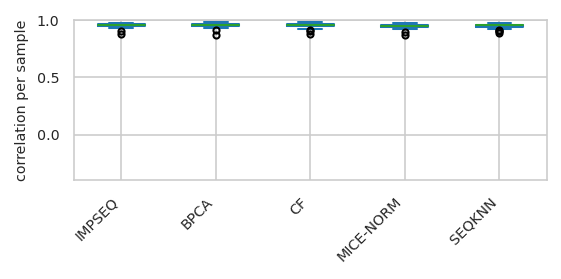

In [26]:
corr_per_sample_val = (pred_val
                       .groupby(sample_index_name)
                       .apply(
                           lambda df: df.corr().loc[TARGET_COL]
                       )[ORDER_MODELS])

min_corr = int(corr_per_sample_val.min().min() * 10) / 10
kwargs = dict(ylim=(min_corr, 1), rot=90,
              #     boxprops=dict(linewidth=1.5),
              flierprops=dict(markersize=3),
              # title='Corr. betw. fake NA and model pred. per sample on validation data',
              ylabel='correlation per sample')
ax = corr_per_sample_val[TOP_N_ORDER].plot.box(**kwargs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_val_per_sample.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

fname = args.out_figures / f'2_{group}_pred_corr_val_per_sample.xlsx'
dumps[fname.stem] = fname
with pd.ExcelWriter(fname) as w:
    corr_per_sample_val.describe().to_excel(w, sheet_name='summary')
    corr_per_sample_val.to_excel(w, sheet_name='correlations')
    corr_per_sample_val[TOP_N_ORDER].to_excel(w, sheet_name='correlations_plotted')

identify samples which are below lower whisker for models

In [27]:
treshold = vaep.pandas.get_lower_whiskers(
    corr_per_sample_val[TOP_N_ORDER]).min()
mask = (corr_per_sample_val[TOP_N_ORDER] < treshold).any(axis=1)
corr_per_sample_val.loc[mask].style.highlight_min(
    axis=1) if mask.sum() else 'Nothing to display'

observed,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,VAE,TRKNN,KNN_IMPUTE,IRM,LLS,MSIMPUTE,ROWMEDIAN,Median,SVDMETHOD,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB
Sample ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,0.880637,0.868166,0.878278,0.866690,0.890069,0.875549,0.809822,0.842542,0.867463,0.865803,0.876656,0.826280,0.832417,0.771055,0.801652,0.831058,0.831058,0.083522,nan,0.704666,-0.093868,nan,0.034652,nan,nan,-0.048036,0.127847
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,0.906543,0.909778,0.904703,0.892209,0.907506,0.890557,0.886819,0.886389,0.901361,0.905753,0.885971,0.867359,0.833385,0.430008,0.822204,0.852373,0.852373,-0.023501,nan,0.796703,-0.063758,nan,-0.071043,nan,nan,0.196388,-0.070317


### Error plot

In [28]:
c_error_min = 4.5
mask = (errors_val[MODELS].abs() > c_error_min).any(axis=1)
errors_val.loc[mask].sort_index(level=1).head()

,,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MLE,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,,,
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,AAAS,0.025,0.251,0.108,0.192,-0.063,0.245,0.859,0.292,NaN,0.884,...,-475.205,-0.117,-2.749,-1.986,-0.096,0.025,0.490,0.989,0.548,-27.594
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,AAAS,4.954,2.047,0.164,3.066,2.712,1.606,4.099,0.701,33.781,0.035,...,0.659,1.779,-0.287,2.590,3.217,4.954,1.659,4.140,2.666,-22.666
2020_01_20_15_10_Q-Exactive-HF-X-Orbitrap_6070,AACS,0.492,2.170,2.644,2.289,1.978,2.325,3.878,2.419,NaN,2.026,...,3.460,1.045,0.060,-1.217,2.031,0.492,2.796,4.132,1.940,-25.257
2020_03_06_16_22_Q-Exactive-HF-X-Orbitrap_6070,AACS,1.943,0.908,-0.393,1.346,0.893,0.238,3.096,0.174,NaN,0.571,...,1.782,-0.046,-2.420,-1.820,1.181,1.943,1.053,3.402,0.602,-23.806
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,AAMDC,1.086,-0.320,-1.097,0.013,-0.658,-0.291,3.450,-0.821,NaN,-1.062,...,-9.521,-1.255,1.515,-5.214,-0.933,1.086,-0.035,3.781,0.091,-24.433


In [29]:
errors_val = errors_val.abs().groupby(
    freq_feat.index.name).mean()  # absolute error
errors_val = errors_val.join(freq_feat)
errors_val = errors_val.sort_values(by=freq_feat.name, ascending=True)
errors_val.head()

,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO,freq
Gene Names,,,,,,,,,,,,,,,,,,,,,
MSRB3,1.222,0.333,0.543,0.739,0.761,0.705,3.931,0.503,NaN,1.742,...,3.208,0.289,4.270,0.197,1.222,1.314,4.212,0.862,23.820,12
ACTA2;ACTG2,0.599,2.423,2.938,2.485,4.198,3.330,2.549,3.659,NaN,3.205,...,1.404,1.721,9.978,2.839,0.599,2.443,2.813,3.163,25.904,12
LAMTOR4,0.385,0.312,0.302,0.246,0.518,0.382,3.649,0.398,NaN,0.427,...,3.170,0.483,6.296,0.227,0.385,0.756,3.873,0.306,24.384,12
RAPH1,1.081,1.688,1.588,1.489,1.815,1.627,1.491,1.758,NaN,1.494,...,5.297,2.753,4.418,1.826,1.081,1.612,1.828,0.919,26.581,12
UHRF2,1.997,0.913,0.692,0.455,1.630,0.541,3.663,0.585,"2,455.881",0.502,...,3.732,1.584,8.185,1.705,1.997,0.760,3.966,2.006,24.165,12


In [30]:
errors_val.describe()[ORDER_MODELS].T  # mean of means

,count,mean,std,min,25%,50%,75%,max
IMPSEQ,"3,831.000",0.536,0.464,0.000,0.216,0.412,0.730,5.508
BPCA,"3,831.000",0.535,0.460,0.001,0.219,0.416,0.727,4.371
CF,"3,831.000",0.555,0.476,0.001,0.228,0.431,0.749,5.260
MICE-NORM,"3,831.000",0.591,0.469,0.000,0.275,0.480,0.773,4.402
SEQKNN,"3,831.000",0.597,0.495,0.000,0.244,0.471,0.810,5.490
MICE-CART,"3,831.000",0.598,0.497,0.000,0.255,0.475,0.798,5.321
DAE,"3,831.000",0.608,0.516,0.000,0.263,0.489,0.812,6.218
RF,"3,831.000",0.612,0.508,0.001,0.265,0.484,0.818,4.991
KNN,"3,831.000",0.630,0.538,0.000,0.259,0.490,0.852,5.715
VAE,"3,831.000",0.651,0.533,0.002,0.288,0.512,0.868,5.474


In [31]:
c_avg_error = 2
mask = (errors_val[TOP_N_ORDER] >= c_avg_error).any(axis=1)
errors_val.loc[mask]

,Median,CF,DAE,VAE,KNN,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,...,MSIMPUTE,PI,QRILC,RF,ROWMEDIAN,SEQKNN,SVDMETHOD,TRKNN,ZERO,freq
Gene Names,,,,,,,,,,,,,,,,,,,,,
ACTA2;ACTG2,0.599,2.423,2.938,2.485,4.198,3.330,2.549,3.659,NaN,3.205,...,1.404,1.721,9.978,2.839,0.599,2.443,2.813,3.163,25.904,12
TNFAIP2,3.424,1.581,0.511,0.446,1.763,0.425,6.492,0.409,NaN,0.628,...,2.247,2.388,1.268,1.214,3.424,2.052,6.371,1.197,20.188,12
AKR1C1,1.118,2.194,2.241,1.142,2.170,1.936,3.321,1.541,NaN,1.244,...,5.305,6.803,13.457,2.545,1.118,2.153,3.070,1.268,32.119,13
TUBB2A,0.529,1.812,1.551,0.424,0.506,1.673,2.887,1.997,NaN,2.807,...,0.653,1.441,3.184,2.334,0.529,2.190,3.083,1.176,26.248,13
MGLL,3.778,1.856,1.846,2.421,2.659,2.518,4.902,2.115,"2,586.668",2.501,...,0.872,0.661,1.105,2.434,3.778,1.945,5.175,3.223,22.347,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PPP1CA,0.920,1.372,2.352,1.167,2.026,2.107,3.556,1.982,NaN,2.426,...,2.396,8.104,3.937,1.429,0.920,1.579,3.263,1.786,31.347,50
POLDIP2,2.889,1.878,2.043,2.619,2.534,2.338,2.942,2.440,NaN,3.451,...,1.402,1.560,0.794,2.167,2.889,1.739,3.268,2.421,24.941,50
PFDN1,1.056,0.847,1.144,0.807,0.942,1.198,0.425,2.081,NaN,0.320,...,0.203,3.868,1.242,0.448,1.056,0.554,0.791,0.202,27.239,50


### Error by non-decimal number of intensity
- number of observations in parentheses.

vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/2_1_errors_binned_by_feat_median_val.pdf


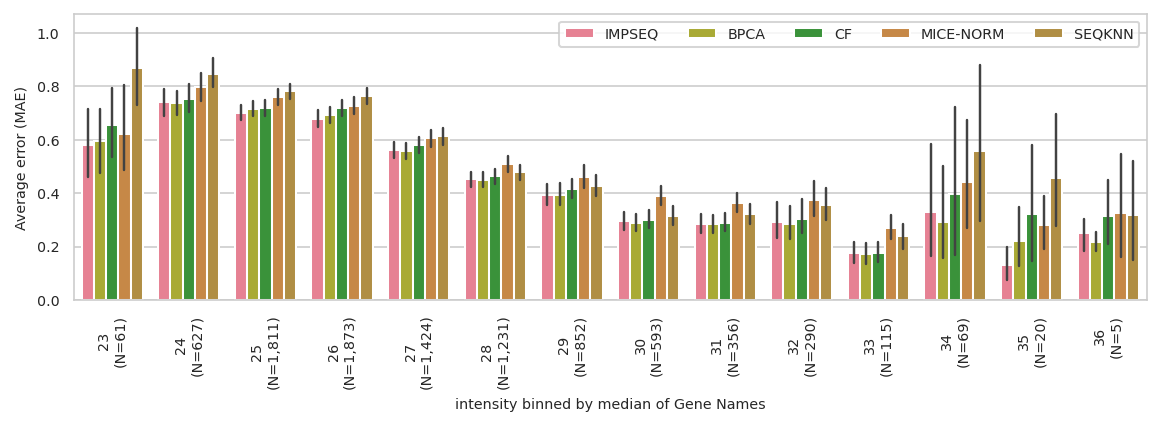

In [32]:
fig, ax = plt.subplots(figsize=(8, 3))
ax, errors_binned = vaep.plotting.errors.plot_errors_by_median(
    pred_val[
        [TARGET_COL] + TOP_N_ORDER
    ],
    feat_medians=data.train_X.median(),
    ax=ax,
    feat_name=FEAT_NAME_DISPLAY,
    palette=TOP_N_COLOR_PALETTE,
    metric_name=METRIC,)
ax.set_ylabel(f"Average error ({METRIC})")
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
fname = args.out_figures / f'2_{group}_errors_binned_by_feat_median_val.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

In [33]:
# ! only used for reporting
plotted = vaep.plotting.errors.get_data_for_errors_by_median(
    errors=errors_binned,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC
)
plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
plotted

,bin,model,mean,ci_low,ci_high
0,23\n(N=61),IMPSEQ,0.581,0.456,0.711
1,23\n(N=61),BPCA,0.597,0.479,0.727
2,23\n(N=61),CF,0.656,0.527,0.786
3,23\n(N=61),MICE-NORM,0.623,0.483,0.783
4,23\n(N=61),SEQKNN,0.869,0.728,1.028
...,...,...,...,...,...
65,36\n(N=5),IMPSEQ,0.250,0.182,0.303
66,36\n(N=5),BPCA,0.217,0.184,0.255
67,36\n(N=5),CF,0.315,0.211,0.450
68,36\n(N=5),MICE-NORM,0.325,0.163,0.537


In [34]:
errors_binned.head()
dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned.head()

,Sample ID,Gene Names,model,MAE,bin,n_obs,intensity binned by median of Gene Names
0,2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,IMPSEQ,0.650,28,"1,231","28\n(N=1,231)"
1,2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,BPCA,0.620,28,"1,231","28\n(N=1,231)"
2,2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,CF,0.781,28,"1,231","28\n(N=1,231)"
3,2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,MICE-NORM,0.840,28,"1,231","28\n(N=1,231)"
4,2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,SEH1L,SEQKNN,0.785,28,"1,231","28\n(N=1,231)"


## test data

In [35]:
pred_test = compare_predictions.load_split_prediction_by_modelkey(
    experiment_folder=args.folder_experiment,
    split='test',
    model_keys=MODELS_PASSED,
    shared_columns=[TARGET_COL])
pred_test = pred_test[[TARGET_COL] + ORDER_MODELS]
pred_test = pred_test.join(freq_feat, on=freq_feat.index.name)
if args.save_agg_pred:
    fname = args.folder_experiment / '01_2_agg_pred_test.csv'
    dumps[fname.stem] = fname
    pred_test.to_csv(fname)
    logger.info(f"Saved aggregated predictions to: {fname}")
pred_test

observed  \
Sample ID                                      Gene Names                   
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1               29.538   
                                               ACTN4               33.270   
                                               ADD3                24.259   
                                               ALCAM               24.906   
                                               ALDH1B1             26.674   
...                                                                   ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3               25.040   
                                               YTHDF3              28.717   
                                               ZC3H11A             28.935   
                                               ZFP91-CNTF;ZFP91    25.662   
                                               hCG_2014768;TMA7    29.212   

                                                                 IMPSEQ  \
Sample ID                                      Gene Names                 
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1             29.889   
                                               ACTN4             33.267   
                                               ADD3              25.092   
                                               ALCAM             24.142   
                                               ALDH1B1           27.006   
...                                                                 ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3             25.668   
                                               YTHDF3            28.423   
                                               ZC3H11A           29.249   
                                               ZFP91-CNTF;ZFP91  26.494   
                                               hCG_2014768;TMA7  28.888   

                                                                  BPCA     CF  \
Sample ID                                      Gene Names                       
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1            29.793 29.848   
                                               ACTN4            33.333 33.273   
                                               ADD3             25.049 24.921   
                                               ALCAM            24.191 24.396   
                                               ALDH1B1          26.961 26.837   
...                                                                ...    ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3            25.706 25.483   
                                               YTHDF3           28.477 28.494   
                                               ZC3H11A          29.254 29.728   
                                               ZFP91-CNTF;ZFP91 26.490 26.709   
                                               hCG_2014768;TMA7 28.878 28.359   

                                                                 MICE-NORM  \
Sample ID                                      Gene Names                    
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ABCE1                29.673   
                                               ACTN4                33.413   
                                               ADD3                 25.150   
                                               ALCAM                24.026   
                                               ALDH1B1              26.667   
...                                                                    ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 YIPF3                26.058   
                                               YTHDF3               28.706   
                                               ZC3H11A              29.362   
                                               ZFP91-CNTF;ZFP91     26.483   
                                               hCG_2014768;TMA7     29.654   

                  

Write averages for all models to excel (from before?)

In [36]:
errors_test_mae = vaep.pandas.calc_errors.get_absolute_error(
    pred_test
)
mae_stats_ordered_test = errors_test_mae.describe()[ORDER_MODELS]
mae_stats_ordered_test

,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,VAE,...,SVDMETHOD,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB
count,"9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","9,327.000",...,"9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","9,327.000","2,207.000"
mean,0.553,0.557,0.570,0.613,0.610,0.616,0.630,0.636,0.654,0.676,...,2.260,2.299,2.600,3.684,3.983,4.082,7.159,27.230,"1,825.418","2,309.947"
std,0.623,0.627,0.628,0.639,0.651,0.673,0.680,0.697,0.720,0.712,...,1.551,1.523,1.688,2.618,2.614,2.768,2.888,2.888,"1,038.315",573.494
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.004,0.000,0.001,0.000,0.000,0.057,19.974,0.000,0.023
25%,0.149,0.153,0.158,0.190,0.173,0.180,0.181,0.184,0.189,0.207,...,0.953,1.074,1.378,1.553,1.907,1.823,4.834,24.905,835.988,"2,388.350"
50%,0.356,0.359,0.373,0.430,0.408,0.401,0.412,0.423,0.421,0.455,...,2.079,2.127,2.395,3.221,3.580,3.669,6.858,26.929,"2,402.607","2,457.675"
75%,0.731,0.740,0.765,0.807,0.823,0.820,0.849,0.842,0.868,0.901,...,3.333,3.309,3.513,5.405,5.720,5.920,9.103,29.174,"2,457.726","2,533.273"
max,8.456,8.903,8.272,8.531,8.350,10.180,10.298,10.544,10.564,9.709,...,9.510,9.642,17.914,14.369,14.139,15.167,17.617,37.689,"3,012.016","2,644.422"


In [37]:
mae_stats_ordered_test.to_excel(writer, sheet_name='mae_stats_ordered_test', float_format='%.5f')

In [38]:
cp_mean_perf = pd.concat([
    mae_stats_ordered_val.loc['mean'],
    mae_stats_ordered_test.loc['mean'],
],
    axis=1,
    keys=['val', 'test']
).sort_values(by='val')
cp_mean_perf.to_excel(writer, sheet_name='cp_mean_perf', float_format='%.5f')
cp_mean_perf

,val,test
IMPSEQ,0.552,0.553
BPCA,0.555,0.557
CF,0.573,0.570
MICE-NORM,0.611,0.613
SEQKNN,0.615,0.610
MICE-CART,0.619,0.616
DAE,0.628,0.630
RF,0.633,0.636
KNN,0.651,0.654
VAE,0.672,0.676


In [39]:
writer.close()

### Intensity distribution as histogram
Plot top 4 models predictions for intensities in test data

vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/2_1_intensity_binned_top_4_models_test.pdf


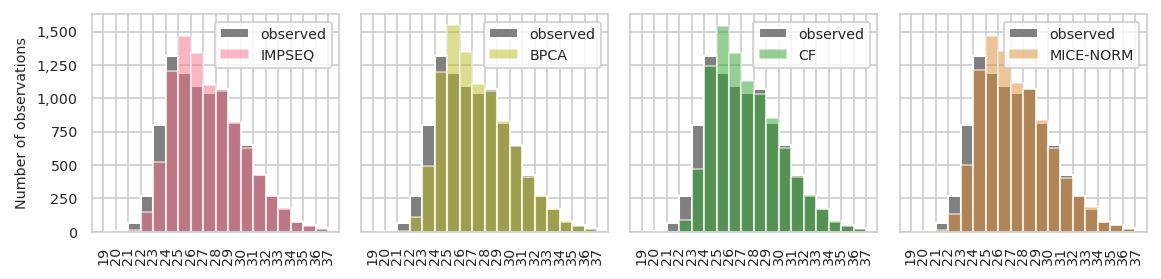

In [40]:
min_max = vaep.plotting.data.min_max(pred_test[TARGET_COL])
top_n = 4
fig, axes = plt.subplots(ncols=top_n, figsize=(8, 2), sharey=True)

for model, color, ax in zip(
        ORDER_MODELS[:top_n],
        COLORS_TO_USE[:top_n],
        axes):

    ax, bins = vaep.plotting.data.plot_histogram_intensities(
        pred_test[TARGET_COL],
        color='grey',
        min_max=min_max,
        ax=ax
    )
    ax, _ = vaep.plotting.data.plot_histogram_intensities(
        pred_test[model],
        color=color,
        min_max=min_max,
        ax=ax,
        alpha=0.5,
    )
    _ = [(l_.set_rotation(90))
         for l_ in ax.get_xticklabels()]
    ax.legend()

axes[0].set_ylabel('Number of observations')

fname = args.out_figures / f'2_{group}_intensity_binned_top_{top_n}_models_test.pdf'
figures[fname.stem] = fname
vaep.savefig(fig, name=fname)

In [41]:
counts_per_bin = vaep.pandas.get_counts_per_bin(df=pred_test,
                                                bins=bins,
                                                columns=[TARGET_COL, *ORDER_MODELS[:top_n]])

counts_per_bin.to_excel(fname.with_suffix('.xlsx'))
counts_per_bin

,observed,IMPSEQ,BPCA,CF,MICE-NORM
bin,,,,,
"(19, 20]",1,0,0,0,0
"(20, 21]",8,2,0,0,1
"(21, 22]",67,13,6,0,11
"(22, 23]",268,145,107,87,133
"(23, 24]",799,520,489,470,503
"(24, 25]","1,314","1,208","1,196","1,241","1,210"
"(25, 26]","1,191","1,467","1,551","1,543","1,465"
"(26, 27]","1,093","1,343","1,347","1,342","1,353"
"(27, 28]","1,040","1,101","1,109","1,128","1,114"


### Correlation per sample

In [42]:
corr_per_sample_test = (pred_test
                        .groupby(sample_index_name)
                        .apply(lambda df: df.corr().loc[TARGET_COL])
                        [ORDER_MODELS])
corr_per_sample_test = corr_per_sample_test.join(
    pred_test
    .groupby(sample_index_name)[TARGET_COL]
    .count()
    .rename('n_obs')
)
too_few_obs = corr_per_sample_test['n_obs'] < 3
corr_per_sample_test.loc[~too_few_obs].describe()

,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,VAE,...,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB,n_obs
count,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,...,0.000,50.000,50.000,0.000,50.000,0.000,0.000,33.000,32.000,50.000
mean,0.951,0.952,0.951,0.945,0.948,0.942,0.942,0.943,0.941,0.947,...,NaN,0.844,-0.010,NaN,-0.007,NaN,NaN,-0.088,-0.218,186.540
std,0.023,0.022,0.018,0.022,0.017,0.022,0.026,0.022,0.022,0.020,...,NaN,0.042,0.062,NaN,0.071,NaN,NaN,0.204,0.157,27.820
min,0.835,0.840,0.870,0.830,0.876,0.840,0.803,0.858,0.857,0.864,...,NaN,0.700,-0.163,NaN,-0.190,NaN,NaN,-0.393,-0.555,145.000
25%,0.943,0.946,0.944,0.936,0.942,0.932,0.934,0.933,0.932,0.941,...,NaN,0.820,-0.039,NaN,-0.045,NaN,NaN,-0.233,-0.312,167.000
50%,0.957,0.957,0.955,0.950,0.952,0.946,0.947,0.946,0.944,0.951,...,NaN,0.854,-0.015,NaN,0.004,NaN,NaN,-0.174,-0.242,176.000
75%,0.964,0.964,0.961,0.957,0.959,0.955,0.957,0.958,0.956,0.958,...,NaN,0.873,0.033,NaN,0.041,NaN,NaN,0.099,-0.119,202.500
max,0.974,0.975,0.973,0.971,0.971,0.967,0.971,0.974,0.973,0.974,...,NaN,0.912,0.106,NaN,0.178,NaN,NaN,0.343,0.278,252.000


vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/2_1_pred_corr_test_per_sample.pdf


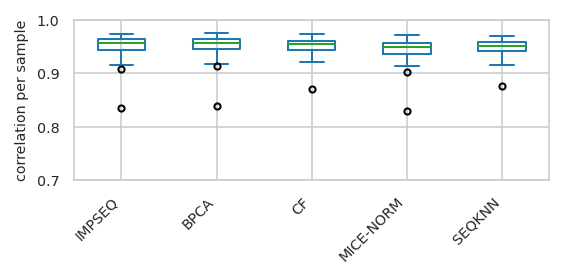

In [43]:
# ! add minimum
kwargs = dict(ylim=(0.7, 1), rot=90,
              flierprops=dict(markersize=3),
              # title='Corr. betw. fake NA and model predictions per sample on test data',
              ylabel='correlation per sample')
ax = (corr_per_sample_test
      .loc[~too_few_obs, TOP_N_ORDER]
      .plot
      .box(**kwargs))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_test_per_sample.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

dumps[fname.stem] = fname.with_suffix('.xlsx')
with pd.ExcelWriter(fname.with_suffix('.xlsx')) as w:
    corr_per_sample_test.describe().to_excel(w, sheet_name='summary')
    corr_per_sample_test.to_excel(w, sheet_name='correlations')
    corr_per_sample_test.loc[~too_few_obs, TOP_N_ORDER].to_excel(w, sheet_name='correlations_plotted')

identify samples which are below lower whisker for models

In [44]:
treshold = vaep.pandas.get_lower_whiskers(
    corr_per_sample_test[TOP_N_ORDER]).min()
mask = (corr_per_sample_test[TOP_N_ORDER] < treshold).any(axis=1)
corr_per_sample_test.loc[mask].style.highlight_min(
    axis=1) if mask.sum() else 'Nothing to display'

,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,VAE,TRKNN,KNN_IMPUTE,IRM,LLS,MSIMPUTE,ROWMEDIAN,Median,SVDMETHOD,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB,n_obs
Sample ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,0.834640,0.839519,0.870282,0.829754,0.875952,0.840471,0.802867,0.857779,0.857402,0.864395,0.866682,0.770436,0.772648,0.676464,0.772519,0.824880,0.824880,0.154034,nan,0.739369,-0.034553,nan,0.066719,nan,nan,0.061267,-0.110129,160
2020_02_17_13_55_Q-Exactive-HF-X-Orbitrap_6070,0.915658,0.918129,0.921352,0.903412,0.916706,0.914176,0.919585,0.919259,0.923941,0.919337,0.916179,0.913695,0.881306,0.867898,0.906384,0.895316,0.895316,0.191910,nan,0.837816,-0.016878,nan,0.063837,nan,nan,-0.207634,-0.303630,169


In [45]:
feature_names = pred_test.index.levels[-1]
N_SAMPLES = pred_test.index
M = len(feature_names)
pred_test.loc[pd.IndexSlice[:, feature_names[random.randint(0, M - 1)]], :]

,,observed,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,...,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB,freq
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,,,
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,MRPL13,26.733,26.858,26.931,27.625,27.076,27.480,26.665,27.691,27.011,26.433,...,27.494,23.051,22.789,22.924,23.729,20.071,0,28.264,NaN,50
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,MRPL13,26.789,26.049,25.771,27.067,25.938,26.424,26.097,27.643,26.526,26.421,...,27.883,20.554,23.818,23.365,23.818,20.071,0,28.946,NaN,50
2020_02_10_15_41_Q-Exactive-HF-X-Orbitrap_6070,MRPL13,28.921,29.417,29.765,30.149,29.770,29.730,28.803,30.091,29.976,31.512,...,29.064,22.701,26.160,24.481,24.408,20.071,0,"2,368.400",NaN,50


In [46]:
options = random.sample(set(feature_names), 1)
pred_test.loc[pd.IndexSlice[:, options[0]], :]

,,observed,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,...,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB,freq
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,,,
2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,TBC1D23,25.261,23.506,23.509,23.668,23.406,23.914,23.833,23.769,23.757,24.026,...,28.024,19.315,23.867,23.364,23.219,20.071,0,"2,405.878",NaN,25
2020_05_12_15_13_Q-Exactive-HF-X-Orbitrap_6070,TBC1D23,22.172,22.521,22.495,22.626,22.573,23.150,22.423,22.169,22.430,22.744,...,26.886,22.921,22.577,22.193,23.853,20.071,0,"2,443.553","2,443.553",25


### Correlation per feature

In [47]:
corr_per_feat_test = pred_test.groupby(FEAT_NAME).apply(
    lambda df: df.corr().loc[TARGET_COL])[ORDER_MODELS]
corr_per_feat_test = corr_per_feat_test.join(pred_test.groupby(FEAT_NAME)[
    TARGET_COL].count().rename('n_obs'))

too_few_obs = corr_per_feat_test['n_obs'] < 3
corr_per_feat_test.loc[~too_few_obs].describe()

,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,VAE,...,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB,n_obs
count,"1,566.000","1,566.000","1,566.000","1,566.000","1,566.000","1,566.000","1,566.000","1,566.000","1,564.000","1,566.000",...,"1,566.000","1,566.000","1,566.000","1,566.000","1,566.000",0.000,0.000,"1,566.000",369.000,"1,566.000"
mean,0.799,0.796,0.794,0.769,0.779,0.756,0.763,0.758,0.743,0.758,...,0.684,-0.013,0.513,0.670,0.381,NaN,NaN,-0.025,-0.268,3.769
std,0.352,0.357,0.359,0.376,0.378,0.392,0.392,0.398,0.413,0.401,...,0.447,0.634,0.529,0.453,0.570,NaN,NaN,0.695,0.862,1.034
min,-0.999,-1.000,-0.999,-1.000,-0.999,-1.000,-1.000,-1.000,-1.000,-0.999,...,-1.000,-1.000,-1.000,-1.000,-1.000,NaN,NaN,-1.000,-1.000,3.000
25%,0.795,0.797,0.786,0.748,0.775,0.730,0.741,0.743,0.733,0.738,...,0.620,-0.579,0.301,0.588,0.056,NaN,NaN,-0.736,-1.000,3.000
50%,0.940,0.938,0.937,0.924,0.933,0.924,0.924,0.922,0.914,0.923,...,0.867,-0.019,0.719,0.856,0.552,NaN,NaN,-0.010,-0.828,3.000
75%,0.986,0.987,0.987,0.980,0.985,0.979,0.986,0.981,0.978,0.981,...,0.966,0.548,0.911,0.965,0.855,NaN,NaN,0.659,0.944,4.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,NaN,NaN,1.000,1.000,10.000


In [48]:
corr_per_feat_test.loc[too_few_obs].dropna(thresh=3, axis=0)

,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,VAE,...,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB,n_obs
Gene Names,,,,,,,,,,,,,,,,,,,,,
AAMDC,1.000,1.000,1.000,-1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,-1.000,1.000,1.000,1.000,NaN,NaN,-1.000,NaN,2
ABCB7,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,-1.000,-1.000,1.000,NaN,NaN,-1.000,NaN,2
ABCC4,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,-1.000,1.000,1.000,1.000,NaN,NaN,-1.000,-1.000,2
ABCE1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,-1.000,-1.000,-1.000,1.000,1.000,NaN,NaN,1.000,1.000,2
ABHD11,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,-1.000,1.000,1.000,-1.000,NaN,NaN,1.000,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF830,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,NaN,NaN,-1.000,NaN,2
ZPR1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,-1.000,-1.000,-1.000,-1.000,1.000,NaN,NaN,-1.000,NaN,2
ZW10,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,NaN,NaN,-1.000,NaN,2


vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/2_1_pred_corr_test_per_feat.pdf


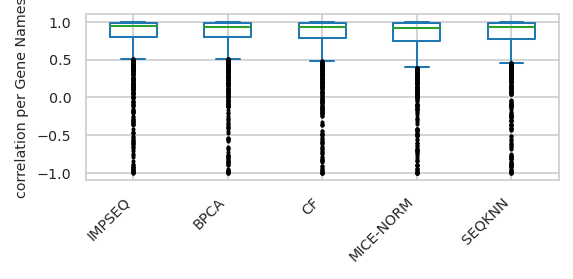

In [49]:
kwargs = dict(rot=90,
              flierprops=dict(markersize=1),
              ylabel=f'correlation per {FEAT_NAME_DISPLAY}')
ax = (corr_per_feat_test
      .loc[~too_few_obs, TOP_N_ORDER]
      .plot
      .box(**kwargs)
      )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                       horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_test_per_feat.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)
dumps[fname.stem] = fname.with_suffix('.xlsx')
with pd.ExcelWriter(fname.with_suffix('.xlsx')) as w:
    corr_per_feat_test.loc[~too_few_obs].describe().to_excel(
        w, sheet_name='summary')
    corr_per_feat_test.to_excel(w, sheet_name='correlations')
    corr_per_feat_test.loc[~too_few_obs, TOP_N_ORDER].to_excel(w, sheet_name='correlations_plotted')

In [50]:
feat_count_test = data.test_y.stack().groupby(FEAT_NAME).count()
feat_count_test.name = 'count'
feat_count_test.head()

Gene Names
AAAS    3
AACS    1
AAMDC   2
AAMP    3
AAR2    4
Name: count, dtype: int64

In [51]:
treshold = vaep.pandas.get_lower_whiskers(
    corr_per_feat_test[TOP_N_ORDER]).min()
mask = (corr_per_feat_test[TOP_N_ORDER] < treshold).any(axis=1)


def highlight_min(s, color, tolerence=0.00001):
    return np.where((s - s.min()).abs() < tolerence, f"background-color: {color};", None)


view = (corr_per_feat_test
        .join(feat_count_test)
        .loc[mask]
        .sort_values('count'))

if not view.empty:
    display(view
            .style.
            apply(highlight_min, color='yellow', axis=1,
                  subset=corr_per_feat_test.columns)
            )
else:
    print("None found")

,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN,MICE-CART,DAE,RF,KNN,VAE,TRKNN,KNN_IMPUTE,IRM,LLS,MSIMPUTE,ROWMEDIAN,Median,SVDMETHOD,COLMEDIAN,QRILC,PI,MINDET,MINPROB,MINIMUM,ZERO,MLE,IMPSEQROB,n_obs,count
Gene Names,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAMDC,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,nan,nan,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,nan,nan,-1.000000,nan,2,2
NUP43,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,nan,nan,1.000000,nan,2,2
NSMCE2,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,nan,nan,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,nan,nan,1.000000,nan,2,2
NSFL1C,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,nan,nan,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,nan,nan,-1.000000,nan,2,2
NOSIP,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,nan,nan,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,nan,nan,1.000000,-1.000000,2,2
NMT1,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,nan,-1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,nan,nan,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,nan,nan,-1.000000,nan,2,2
NEMF,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,nan,1.000000,nan,2,2
NDUFS6,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,nan,nan,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,nan,nan,1.000000,nan,2,2
NDUFAF4,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,nan,nan,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,nan,nan,-1.000000,nan,2,2


### Error plot

In [52]:
metrics = vaep.models.Metrics()
test_metrics = metrics.add_metrics(
    pred_test[['observed', *TOP_N_ORDER]], key='test data')
test_metrics = pd.DataFrame(test_metrics)[TOP_N_ORDER]
test_metrics

Selected as truth to compare to: observed


,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN
MSE,0.695,0.704,0.720,0.784,0.797
MAE,0.553,0.557,0.570,0.613,0.610
N,"9,327.000","9,327.000","9,327.000","9,327.000","9,327.000"
prop,1.000,1.000,1.000,1.000,1.000


In [53]:
n_in_comparison = int(test_metrics.loc['N'].unique()[0])
n_in_comparison

9327

In [54]:
_to_plot = test_metrics.loc[METRIC].to_frame().T
_to_plot.index = [feature_names.name]
_to_plot

,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN
Gene Names,0.553,0.557,0.570,0.613,0.610


In [55]:
try:
    text = model_configs[["latent_dim", "hidden_layers"]].apply(
        build_text,
        axis=1)
except KeyError:
    logger.warning("No PIMMS models in comparsion. Using empty text")
    text = pd.Series('', index=model_configs.columns)

_to_plot.loc["text"] = text
_to_plot = _to_plot.fillna('')
_to_plot

,IMPSEQ,BPCA,CF,MICE-NORM,SEQKNN
Gene Names,0.553,0.557,0.570,0.613,0.610
text,,,LD: 50,,


vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/2_1_performance_test.pdf


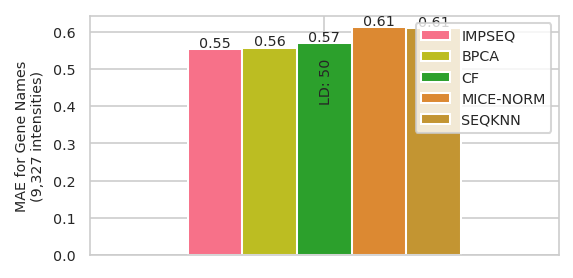

In [56]:
fig, ax = plt.subplots(figsize=(4, 2))  # size of the plot can be adjusted
ax = _to_plot.loc[[feature_names.name]].plot.bar(
    rot=0,
    ylabel=f"{METRIC} for {FEAT_NAME_DISPLAY}\n({n_in_comparison:,} intensities)",
    # title=f'performance on test data (based on {n_in_comparison:,} measurements)',
    color=COLORS_TO_USE,
    ax=ax,
    width=.7)
ax = vaep.plotting.add_height_to_barplot(ax, size=7)
ax = vaep.plotting.add_text_to_barplot(ax, _to_plot.loc["text"], size=7)
ax.set_xticklabels([])
fname = args.out_figures / f'2_{group}_performance_test.pdf'
figures[fname.stem] = fname
vaep.savefig(fig, name=fname)

In [57]:
dumps[fname.stem] = fname.with_suffix('.csv')
_to_plot_long = _to_plot.T
_to_plot_long = _to_plot_long.rename(
    {feature_names.name: 'metric_value'}, axis=1)
_to_plot_long['data level'] = feature_names.name
_to_plot_long = _to_plot_long.set_index('data level', append=True)
_to_plot_long.to_csv(fname.with_suffix('.csv'))

### Plot error by median feature intensity

vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/2_1_test_errors_binned_by_feat_medians.pdf


,Sample ID,Gene Names,model,MAE,bin,n_obs,intensity binned by median of Gene Names
0,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,IMPSEQ,0.351,30,563,30\n(N=563)
1,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,BPCA,0.255,30,563,30\n(N=563)
2,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,CF,0.311,30,563,30\n(N=563)
3,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,MICE-NORM,0.136,30,563,30\n(N=563)
4,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,SEQKNN,0.286,30,563,30\n(N=563)
...,...,...,...,...,...,...,...
"46,630",2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070,hCG_2014768;TMA7,IMPSEQ,0.324,28,"1,165","28\n(N=1,165)"
"46,631",2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070,hCG_2014768;TMA7,BPCA,0.335,28,"1,165","28\n(N=1,165)"
"46,632",2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070,hCG_2014768;TMA7,CF,0.853,28,"1,165","28\n(N=1,165)"
"46,633",2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070,hCG_2014768;TMA7,MICE-NORM,0.442,28,"1,165","28\n(N=1,165)"


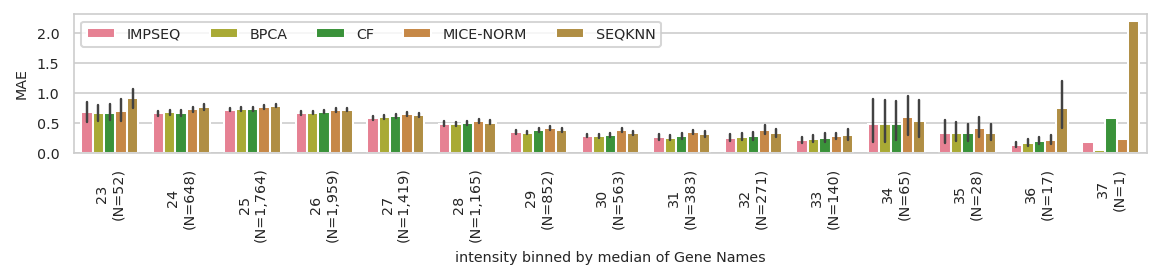

In [58]:
vaep.plotting.make_large_descriptors(7)
fig, ax = plt.subplots(figsize=(8, 2))

ax, errors_binned = vaep.plotting.errors.plot_errors_by_median(
    pred=pred_test[
        [TARGET_COL] + TOP_N_ORDER
    ],
    feat_medians=data.train_X.median(),
    ax=ax,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC,
    palette=COLORS_TO_USE
)
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
vaep.plotting.make_large_descriptors(6)
fname = args.out_figures / f'2_{group}_test_errors_binned_by_feat_medians.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned

In [59]:
# ! only used for reporting
plotted = vaep.plotting.errors.get_data_for_errors_by_median(
    errors=errors_binned,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC
)
plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
plotted

,bin,model,mean,ci_low,ci_high
0,23\n(N=52),IMPSEQ,0.677,0.517,0.834
1,23\n(N=52),BPCA,0.668,0.526,0.813
2,23\n(N=52),CF,0.676,0.548,0.819
3,23\n(N=52),MICE-NORM,0.702,0.538,0.895
4,23\n(N=52),SEQKNN,0.916,0.764,1.087
...,...,...,...,...,...
70,37\n(N=1),IMPSEQ,0.186,NaN,NaN
71,37\n(N=1),BPCA,0.044,NaN,NaN
72,37\n(N=1),CF,0.588,NaN,NaN
73,37\n(N=1),MICE-NORM,0.234,NaN,NaN


In [60]:
(errors_binned
 .set_index(
     ['model', errors_binned.columns[-1]]
 )
 .loc[ORDER_MODELS[0]]
 .sort_values(by=METRIC))

,Sample ID,Gene Names,MAE,bin,n_obs
intensity binned by median of Gene Names,,,,,
31\n(N=383),2020_03_11_11_25_Q-Exactive-HF-X-Orbitrap_6070,COPA,0.000,31,383
29\n(N=852),2020_05_12_21_07_Q-Exactive-HF-X-Orbitrap_6070,CLIP1,0.000,29,852
"26\n(N=1,959)",2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,TIGAR,0.000,26,"1,959"
"27\n(N=1,419)",2020_05_22_17_43_Q-Exactive-HF-X-Orbitrap_6070,KIF4A;KIF4B,0.000,27,"1,419"
30\n(N=563),2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,DARS,0.000,30,563
...,...,...,...,...,...
32\n(N=271),2020_05_22_14_57_Q-Exactive-HF-X-Orbitrap_6070,PCBP2,7.498,32,271
"28\n(N=1,165)",2020_02_05_20_55_Q-Exactive-HF-X-Orbitrap_6070,COX7C,7.950,28,"1,165"
34\n(N=65),2020_02_18_01_25_Q-Exactive-HF-X-Orbitrap_6070,HNRNPA1;HNRNPA1L2,8.064,34,65


### Custom model selection

In [61]:
if SEL_MODELS:
    metrics = vaep.models.Metrics()
    test_metrics = metrics.add_metrics(
        pred_test[['observed', *SEL_MODELS]], key='test data')
    test_metrics = pd.DataFrame(test_metrics)[SEL_MODELS]
    test_metrics

    n_in_comparison = int(test_metrics.loc['N'].unique()[0])
    n_in_comparison

    _to_plot = test_metrics.loc[METRIC].to_frame().T
    _to_plot.index = [feature_names.name]
    _to_plot

    try:
        text = model_configs[["latent_dim", "hidden_layers"]].apply(
            build_text,
            axis=1)
    except KeyError:
        logger.warning("No PIMMS models in comparsion. Using empty text")
        text = pd.Series('', index=model_configs.columns)

    _to_plot.loc["text"] = text
    _to_plot = _to_plot.fillna('')
    _to_plot

    fig, ax = plt.subplots(figsize=(4, 2))
    ax = _to_plot.loc[[feature_names.name]].plot.bar(
        rot=0,
        ylabel=f"{METRIC} for {FEAT_NAME_DISPLAY} ({n_in_comparison:,} intensities)",
        # title=f'performance on test data (based on {n_in_comparison:,} measurements)',
        color=vaep.plotting.defaults.assign_colors(
            list(k.upper() for k in SEL_MODELS)),
        ax=ax,
        width=.7)
    ax.legend(loc='best', ncols=len(SEL_MODELS))
    ax = vaep.plotting.add_height_to_barplot(ax, size=5)
    ax = vaep.plotting.add_text_to_barplot(ax, _to_plot.loc["text"], size=5)
    ax.set_xticklabels([])

    fname = args.out_figures / f'2_{group}_performance_test_sel.pdf'
    figures[fname.stem] = fname
    vaep.savefig(fig, name=fname)

    dumps[fname.stem] = fname.with_suffix('.csv')
    _to_plot_long = _to_plot.T
    _to_plot_long = _to_plot_long.rename(
        {feature_names.name: 'metric_value'}, axis=1)
    _to_plot_long['data level'] = feature_names.name
    _to_plot_long = _to_plot_long.set_index('data level', append=True)
    _to_plot_long.to_csv(fname.with_suffix('.csv'))

In [62]:
# custom selection
if SEL_MODELS:
    vaep.plotting.make_large_descriptors(7)
    fig, ax = plt.subplots(figsize=(8, 2))

    ax, errors_binned = vaep.plotting.errors.plot_errors_by_median(
        pred=pred_test[
            [TARGET_COL] + SEL_MODELS
        ],
        feat_medians=data.train_X.median(),
        ax=ax,
        metric_name=METRIC,
        feat_name=FEAT_NAME_DISPLAY,
        palette=vaep.plotting.defaults.assign_colors(
            list(k.upper() for k in SEL_MODELS))
    )
    # ax.set_ylim(0, 1.5)
    ax.legend(loc='best', ncols=len(SEL_MODELS))
    # for text in ax.legend().get_texts():
    #     text.set_fontsize(6)
    fname = args.out_figures / f'2_{group}_test_errors_binned_by_feat_medians_sel.pdf'
    figures[fname.stem] = fname
    vaep.savefig(ax.get_figure(), name=fname)
    plt.show(fig)

    dumps[fname.stem] = fname.with_suffix('.csv')
    errors_binned.to_csv(fname.with_suffix('.csv'))
    vaep.plotting.make_large_descriptors(6)
    # ax.xaxis.set_tick_params(rotation=0) # horizontal

    # ! only used for reporting
    plotted = vaep.plotting.errors.get_data_for_errors_by_median(
        errors=errors_binned,
        feat_name=FEAT_NAME_DISPLAY,
        metric_name=METRIC
    )
    plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
    display(plotted)

### Error by non-decimal number of intensity

- number of observations in parentheses.

vaep.plotting - INFO     Saved Figures to runs/dev_dataset_small/proteinGroups_N50/figures/2_1_test_errors_binned_by_int.pdf


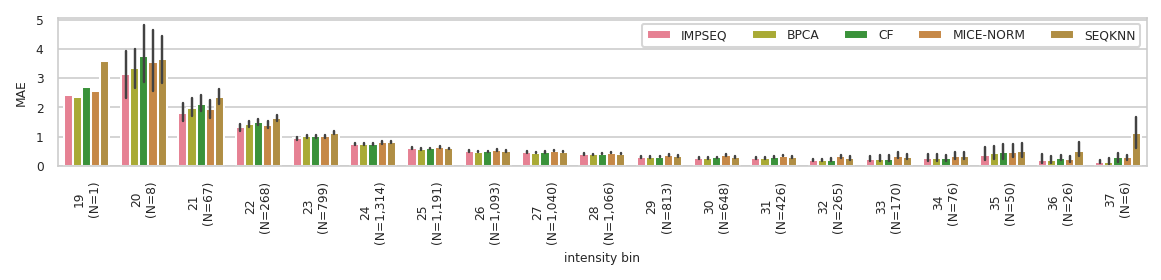

In [63]:
fig, ax = plt.subplots(figsize=(8, 2))
ax, errors_binned = vaep.plotting.errors.plot_errors_binned(
    pred_test[
        [TARGET_COL] + TOP_N_ORDER
    ],
    ax=ax,
    palette=TOP_N_COLOR_PALETTE,
    metric_name=METRIC,
)
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
fname = args.out_figures / f'2_{group}_test_errors_binned_by_int.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

In [64]:
dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned.head()

,Sample ID,Gene Names,model,MAE,intensity bin
0,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,IMPSEQ,0.351,29\n(N=813)
1,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,BPCA,0.255,29\n(N=813)
2,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,CF,0.311,29\n(N=813)
3,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,MICE-NORM,0.136,29\n(N=813)
4,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ABCE1,SEQKNN,0.286,29\n(N=813)


## Figures dumped to disk

In [65]:
figures

{'2_1_fake_na_val_test_splits': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_fake_na_val_test_splits.png'),
 '2_1_pred_corr_val_per_sample': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_pred_corr_val_per_sample.pdf'),
 '2_1_errors_binned_by_feat_median_val': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_errors_binned_by_feat_median_val.pdf'),
 '2_1_intensity_binned_top_4_models_test': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_intensity_binned_top_4_models_test.pdf'),
 '2_1_pred_corr_test_per_sample': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_pred_corr_test_per_sample.pdf'),
 '2_1_pred_corr_test_per_feat': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_pred_corr_test_per_feat.pdf'),
 '2_1_performance_test': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_performance_test.pdf'),
 '2_1_test_errors_binned_by_feat_medians': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_test_errors_

In [66]:
dumps

{'01_2_performance_summary': Path('runs/dev_dataset_small/proteinGroups_N50/01_2_performance_summary.xlsx'),
 '2_1_pred_corr_val_per_sample': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_pred_corr_val_per_sample.xlsx'),
 '2_1_errors_binned_by_feat_median_val': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_errors_binned_by_feat_median_val.csv'),
 '2_1_pred_corr_test_per_sample': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_pred_corr_test_per_sample.xlsx'),
 '2_1_pred_corr_test_per_feat': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_pred_corr_test_per_feat.xlsx'),
 '2_1_performance_test': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_performance_test.csv'),
 '2_1_test_errors_binned_by_feat_medians': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_test_errors_binned_by_feat_medians.csv'),
 '2_1_test_errors_binned_by_int': Path('runs/dev_dataset_small/proteinGroups_N50/figures/2_1_test_errors_binned_by_int.csv')